<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RBSeq2Seq_Train_Loop_GRU_Masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I will use the entire day of rides and the target asset rides to train the model on the target asset but still give provide the dimensionality to the model which will allow for variable length inputs so a model can be trained for each asset, and be able to take rides from the day of rides and output it's selection from it. This model cloned for other assets should produce a schedule where the no dispatcher needed to be involved to schedule 99% of the rides. Later, human dispatchers can alter the rides so that the model continues to learn from humans in real time, giving the model even more precision and generalization capabilities with rides it's never seen.

In [71]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [72]:
rides = pd.read_csv('/content/run_103.csv')

In [73]:
rides = rides.drop(['Unnamed: 0',
                    'order',
                    'rider.first_name',
                    'rider.last_name',
                    'pickup.event_location.address1',
                    'dropoff.event_location.address1',
                    'run_name_id',
                    'pickup_time',
                    ], axis=1)


In [74]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,1.000000,0.020619,0.0,0.045455,0.300000,-0.996971,0.993242,0.03125,-0.997400,0.994884,1.0,2.0,0.000000,1.000000
1,0.333333,0.005055,0.0,0.257576,0.600000,-0.996493,0.993262,0.81250,-0.996241,0.993313,1.0,2.0,0.083333,0.333333
2,1.000000,0.007725,0.0,0.515151,0.600000,-0.996372,0.992653,0.81250,-0.996193,0.992977,1.0,2.0,0.166667,0.000000
3,0.333333,0.062177,0.0,0.272727,0.333333,-0.993221,0.985946,0.59375,-0.994925,0.990800,1.0,2.0,0.333333,0.000000
4,0.333333,0.013177,0.0,0.151515,0.466667,-0.995843,0.993297,0.81250,-0.996241,0.993314,1.0,2.0,0.416667,0.000000


In [75]:
rides = rides.astype('float32')
rides['run_name'] = rides['run_name'].astype(int)

In [76]:
# Count the number of NaN values in each column
nan_counts = rides.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

space_type                          0
billable_distance                   0
run_name                            0
rider.mediroutes_rider_id           0
pickup.event_location.zip           0
pickup.event_location.longitude     0
pickup.event_location.latitude      0
dropoff.event_location.zip          0
dropoff.event_location.longitude    0
dropoff.event_location.latitude     0
pickup_month                        0
pickup_day                          0
pickup_hour                         0
pickup_minute                       0
dtype: int64


In [77]:
rides.fillna(0, inplace=True)

In [78]:
rides.dtypes

space_type                          float32
billable_distance                   float32
run_name                              int64
rider.mediroutes_rider_id           float32
pickup.event_location.zip           float32
pickup.event_location.longitude     float32
pickup.event_location.latitude      float32
dropoff.event_location.zip          float32
dropoff.event_location.longitude    float32
dropoff.event_location.latitude     float32
pickup_month                        float32
pickup_day                          float32
pickup_hour                         float32
pickup_minute                       float32
dtype: object

In [79]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,1.000000,0.020619,0,0.045455,0.300000,-0.996971,0.993242,0.03125,-0.997400,0.994884,1.0,2.0,0.000000,1.000000
1,0.333333,0.005055,0,0.257576,0.600000,-0.996493,0.993262,0.81250,-0.996241,0.993313,1.0,2.0,0.083333,0.333333
2,1.000000,0.007725,0,0.515152,0.600000,-0.996372,0.992653,0.81250,-0.996193,0.992977,1.0,2.0,0.166667,0.000000
3,0.333333,0.062177,0,0.272727,0.333333,-0.993221,0.985946,0.59375,-0.994925,0.990800,1.0,2.0,0.333333,0.000000
4,0.333333,0.013177,0,0.151515,0.466667,-0.995843,0.993297,0.81250,-0.996241,0.993314,1.0,2.0,0.416667,0.000000


In [80]:
counts = rides.groupby(['pickup_month', 'pickup_day']).size().reset_index(name='counts')
counts['counts'].mean()

9.357142857142858

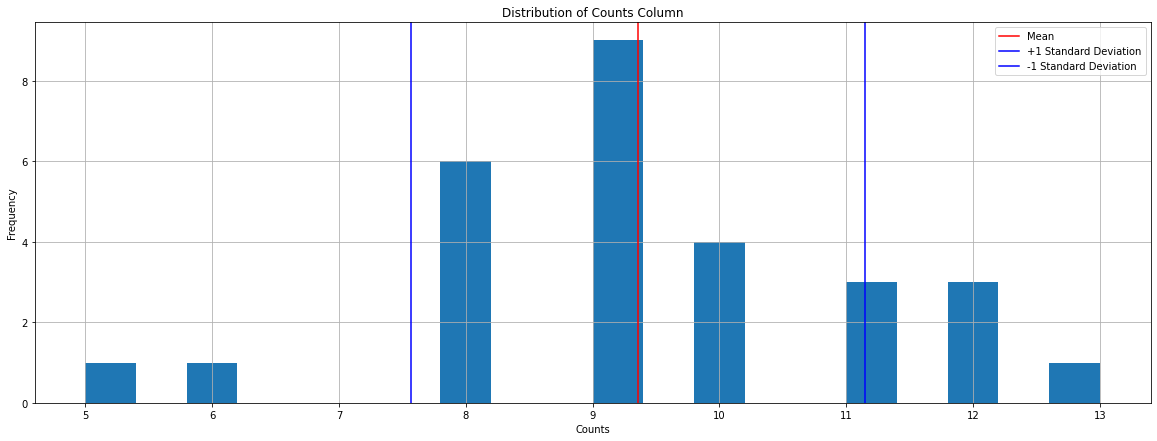

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation of the counts column
mean = counts['counts'].mean()
std = counts['counts'].std()

# Plot the histogram of the counts column
counts['counts'].hist(bins=20)

# Add vertical lines to indicate mean and standard deviation
plt.axvline(mean, color='red', label='Mean')
plt.axvline(mean + std, color='blue', label='+1 Standard Deviation')
plt.axvline(mean - std, color='blue', label='-1 Standard Deviation')

# Add title and labels
plt.title('Distribution of Counts Column')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [82]:
rides['pickup_day'] = rides['pickup_day'].fillna(0).astype(int)
rides['pickup_month'] = rides['pickup_month'].fillna(0).astype(int)

rides['pickup_day'] = rides['pickup_day'].astype(str)
rides['pickup_month'] = rides['pickup_month'].astype(str)

rides['id'] = rides['pickup_month'] + rides['pickup_day']

rides = rides.drop(['pickup_month','pickup_day'], axis=1)

In [83]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,id
0,1.000000,0.020619,0,0.045455,0.300000,-0.996971,0.993242,0.03125,-0.997400,0.994884,0.000000,1.000000,12
1,0.333333,0.005055,0,0.257576,0.600000,-0.996493,0.993262,0.81250,-0.996241,0.993313,0.083333,0.333333,12
2,1.000000,0.007725,0,0.515152,0.600000,-0.996372,0.992653,0.81250,-0.996193,0.992977,0.166667,0.000000,12
3,0.333333,0.062177,0,0.272727,0.333333,-0.993221,0.985946,0.59375,-0.994925,0.990800,0.333333,0.000000,12
4,0.333333,0.013177,0,0.151515,0.466667,-0.995843,0.993297,0.81250,-0.996241,0.993314,0.416667,0.000000,12


In [84]:
rides.shape

(262, 13)

In [85]:
rides = rides.astype(str)

In [86]:
rides.values[0].astype('float32')

array([ 1.      ,  0.020619,  0.      ,  0.045455,  0.3     , -0.996971,
        0.993242,  0.03125 , -0.9974  ,  0.994884,  0.      ,  1.      ,
       12.      ], dtype=float32)

# DAY NUMBER WE ARE TRAINING - SET IT HERE FOR ALL BELOW CODE

In [87]:
len(max(rides, key=len))

32

In [88]:
day_of_rides = 0
sequence_len = 666

Put rides into buckets by date

In [89]:
# Group the rows by the 'id' column
grouped = rides.groupby('id')

# Create a list to store the grouped arrays
day_buckets = []

# Loop through each group
for name, group in grouped:
    # Convert the group to a numpy array
    group_array = group.values.astype(np.float32)
    
    # Append the group array to the list of grouped arrays
    day_buckets.append(group_array)

# Set the display format of the numpy arrays
np.set_printoptions(precision=6, suppress=True)

# Sort the list of grouped arrays by the first column of each array
day_buckets.sort(key=lambda x: x[0][1])


In [90]:
# Do this or when you shuffle below it will shuffle both for some fucking reason, and copy doesn't work.
day_buckets_y = [x.astype(str) for x in day_buckets[1:]]

In [91]:
len(day_buckets_y[9])

12

In [92]:
# Get a look at the run's yearly unique daily schedule lengths
unique_lengths = list(set(len(sub_array) for sub_array in day_buckets_y))

In [93]:
max(unique_lengths)

13

In [94]:
day_buckets_y[0]

array([['1.0', '0.020550499', '0.0', '0.045454547', '0.3', '-0.99697095',
        '0.9932419', '0.03125', '-0.9973999', '0.99488443', '0.0', '1.0',
        '110.0'],
       ['0.33333334', '0.019966312', '0.0', '0.21212122', '0.26666668',
        '-0.99644196', '0.9920201', '0.5625', '-0.9958683', '0.9912264',
        '0.083333336', '1.0', '110.0'],
       ['0.0', '0.050601106', '0.0', '0.10606061', '0.2', '-0.9980458',
        '0.9966702', '0.375', '-0.9967102', '0.9936471', '0.25', '1.0',
        '110.0'],
       ['1.0', '0.02990315', '0.0', '0.22727273', '0.8666667',
        '-0.99619335', '0.992977', '0.96875', '-0.99613476',
        '0.99532086', '0.41666666', '0.6666667', '110.0'],
       ['1.0', '0.012014573', '0.0', '0.43939394', '0.8666667',
        '-0.99619335', '0.992977', '0.71875', '-0.9958649', '0.99306273',
        '0.41666666', '0.6666667', '110.0'],
       ['1.0', '0.0021703742', '0.0', '0.3030303', '0.6', '-0.9964902',
        '0.99326324', '0.59375', '-0.99658185', '

In [95]:
def shuffle_np_array(np_array_list):
    for i in range(len(np_array_list)):
        np.random.shuffle(np_array_list[i])
    return np_array_list

day_buckets_X = shuffle_np_array(day_buckets)[1:] # create a shuffled version for X below

In [96]:
input = []
target = []
for array in day_buckets_X:
    new_array = np.delete(array, -1, axis=1)
    input.append(new_array.astype('float32'))

count = 0
for array in day_buckets_y:
    new_array = np.delete(array, -1, axis=1)
    target.append(new_array.astype('float32'))


# Load the model for the training loop

In [97]:
# Set early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [98]:
# # Create a TensorBoard callback
# import datetime

# logdir = "/content/drive/MyDrive/tensorboard_logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [99]:
def pad_array(arr):

    padding = np.zeros((1, 12))
    while arr.shape[0] < sequence_len:
        arr = np.concatenate((arr, padding), axis=0)
    return arr.astype('float32')

def create_validation_set():
  random_validation_set = np.random.randint(0, len(day_buckets_X))

  if not random_validation_set == day_of_rides:
    print('random_validation_set: ', random_validation_set)
    print('day_of_rides: ', day_of_rides)
    X_val = input[-1].astype('float32')
    X_val = pad_array(X_val)

    y_val = target[-1].astype('float32')
    y_val = pad_array(y_val)

    return X_val, y_val
  else:
    # Recursively call the function until it lands on a random day of rides that doesn't match the training tensor.
    create_validation_set()

In [100]:
# dummy = np.zeros((1,200,12))
# dummy.shape
# pred = model.predict([input_, dummy])

# pred[0][1]

In [101]:
p_test = pad_array(input[day_of_rides])
p_test[:15], len(p_test)

(array([[ 1.      ,  0.012015,  0.      ,  0.439394,  0.866667, -0.996193,
          0.992977,  0.71875 , -0.995865,  0.993063,  0.416667,  0.666667],
        [ 1.      ,  0.029903,  0.      ,  0.227273,  0.866667, -0.996193,
          0.992977,  0.96875 , -0.996135,  0.995321,  0.416667,  0.666667],
        [ 1.      ,  0.00217 ,  0.      ,  0.30303 ,  0.6     , -0.99649 ,
          0.993263,  0.59375 , -0.996582,  0.993275,  0.5     ,  0.666667],
        [ 1.      ,  0.02055 ,  0.      ,  0.045455,  0.3     , -0.996971,
          0.993242,  0.03125 , -0.9974  ,  0.994884,  0.      ,  1.      ],
        [ 0.333333,  0.019966,  0.      ,  0.212121,  0.266667, -0.996442,
          0.99202 ,  0.5625  , -0.995868,  0.991226,  0.083333,  1.      ],
        [ 0.      ,  0.050601,  0.      ,  0.106061,  0.2     , -0.998046,
          0.99667 ,  0.375   , -0.99671 ,  0.993647,  0.25    ,  1.      ],
        [ 1.      ,  0.012727,  0.      ,  0.030303,  0.666667, -0.995341,
          0.993172,

In [102]:
test = tf.equal(input[0][:, 2], 0)

In [103]:
test

<tf.Tensor: shape=(8,), dtype=bool, numpy=array([ True,  True,  True,  True,  True,  True,  True,  True])>

In [ ]:
first_run = False

# TRAINING LOOP
start_at = 12
train_until = 30
for day_of_rides in range(start_at, train_until): # num days to be trained

  if not first_run:
    print(f'Training {day_of_rides} of {train_until}')
    model = keras.models.load_model('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')
    print('Model loaded.')

  # Pad the input
  input[day_of_rides] = pad_array(input[day_of_rides])
  target[day_of_rides] = pad_array(target[day_of_rides])

  # Truncate input to defined sequence length
  input[day_of_rides] = input[day_of_rides][:sequence_len]
  target[day_of_rides] = target[day_of_rides][:sequence_len]

  # Create Random Validation Set
  X_val, y_val = create_validation_set()

  # Create Input and Target Df's
  input_df = pd.DataFrame(input[day_of_rides], columns=[
  'input_space_type',
  'input_billable_distance',
  'input_run_name',
  'input_rider.mediroutes_rider_id',
  'input_pickup.event_location.zip',
  'input_pickup.event_location.longitude',
  'input_pickup.event_location.latitude',
  'input_dropoff.event_location.zip',
  'input_dropoff.event_location.longitude',
  'input_dropoff.event_location.latitude',
  'input_pickup_hour',
  'input_pickup_minute'
  ])

  target_df = pd.DataFrame(target[day_of_rides], columns=[
  'target_space_type',
  'target_billable_distance',
  'target_run_name',
  'target_rider.mediroutes_rider_id',
  'target_pickup.event_location.zip',
  'target_pickup.event_location.longitude',
  'target_pickup.event_location.latitude',
  'target_dropoff.event_location.zip',
  'target_dropoff.event_location.longitude',
  'target_dropoff.event_location.latitude',
  'target_pickup_hour',
  'target_pickup_minute'
  ])

  # Define the input and output shape
  input_shape = (sequence_len, 12)
  output_shape = (sequence_len, 12)

  # Set the input and target to the day of rides iteration
  input_orig = input[day_of_rides]
  target_orig = target[day_of_rides]

  input_ = input_orig.reshape(1, *input_orig.shape)
  target_ = target_orig.reshape(1, *target_orig.shape)
  X_val = X_val.reshape(1, *X_val.shape)
  y_val = y_val.reshape(1, *y_val.shape)

  print(input_.shape)
  print(input_.shape)
  print(X_val.shape)
  print(y_val.shape)

  # Define input tensor with variable sequence length
  inputs = keras.layers.Input(shape=(None, 12))

  # Mask to filter out all elements of the input sequence that don't correspond to the target vehicle ID
  mask = keras.layers.Lambda(lambda x: tf.not_equal(tf.reduce_sum(x, axis=-1), 0))(inputs)

  masking = keras.layers.Masking(mask_value=0.0)
  masked_inputs = masking(inputs)

  encoder = keras.layers.GRU(128, return_state=True)
  encoder_outputs, state_h = encoder(masked_inputs, mask=mask)

  encoder_states = [state_h]

  decoder = keras.layers.GRU(128, return_sequences=True)
  decoder_outputs = decoder(masked_inputs, initial_state=encoder_states, mask=mask)

  outputs = keras.layers.Dense(12, activation='linear')(decoder_outputs)


  # Compile the model
  if first_run:
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.mse)

  # Train the model
  history = model.fit(input_, target_, epochs=400, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=2)
  model.save('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')
  print('Model saved.')

Training 12 of 30
Model loaded.
random_validation_set:  24
day_of_rides:  12
(1, 666, 12)
(1, 666, 12)
(1, 666, 12)
(1, 666, 12)
Epoch 1/400
1/1 - 10s - loss: 0.0317 - val_loss: 0.0346 - 10s/epoch - 10s/step
Epoch 2/400
1/1 - 0s - loss: 0.0305 - val_loss: 0.0357 - 41ms/epoch - 41ms/step
Epoch 3/400
1/1 - 0s - loss: 0.0295 - val_loss: 0.0370 - 38ms/epoch - 38ms/step
Epoch 4/400
1/1 - 0s - loss: 0.0286 - val_loss: 0.0384 - 40ms/epoch - 40ms/step
Epoch 5/400
1/1 - 0s - loss: 0.0280 - val_loss: 0.0398 - 38ms/epoch - 38ms/step
Epoch 6/400
1/1 - 0s - loss: 0.0274 - val_loss: 0.0412 - 37ms/epoch - 37ms/step


Model saved.
Training 13 of 30
Model loaded.
random_validation_set:  21
day_of_rides:  13
(1, 666, 12)
(1, 666, 12)
(1, 666, 12)
(1, 666, 12)
Epoch 1/400
1/1 - 11s - loss: 0.0235 - val_loss: 0.0407 - 11s/epoch - 11s/step
Epoch 2/400
1/1 - 0s - loss: 0.0226 - val_loss: 0.0405 - 41ms/epoch - 41ms/step
Epoch 3/400
1/1 - 0s - loss: 0.0218 - val_loss: 0.0406 - 38ms/epoch - 38ms/step
Epoch 4/400
1/1 - 0s - loss: 0.0212 - val_loss: 0.0409 - 38ms/epoch - 38ms/step
Epoch 5/400
1/1 - 0s - loss: 0.0209 - val_loss: 0.0415 - 36ms/epoch - 36ms/step
Epoch 6/400
1/1 - 0s - loss: 0.0206 - val_loss: 0.0421 - 37ms/epoch - 37ms/step
Epoch 7/400
1/1 - 0s - loss: 0.0204 - val_loss: 0.0427 - 54ms/epoch - 54ms/step


In [112]:
pred = model.predict(input_)

1/1 [==============================] - 2s 2s/step


In [113]:
pred[0][0]

array([ 0.525811, -0.003488, -0.075438,  0.169773,  0.291684, -0.988388,
        0.944668,  0.188942, -0.827027,  0.959741,  0.038721,  0.954705],
      dtype=float32)

In [114]:
target_[0][0]

array([ 1.      ,  0.02055 ,  0.      ,  0.045455,  0.3     , -0.996971,
        0.993242,  0.03125 , -0.9974  ,  0.994884,  0.      ,  1.      ],
      dtype=float32)

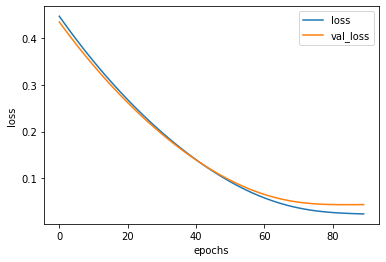

In [115]:
# Plot history (also known as a loss curve)
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_vectors_cosine_similarity(vector1, vector2):
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    fig, ax = plt.subplots()
    ax.plot(vector1, label='Prediction')
    ax.plot(vector2, label='Target')
    ax.set_title('Cosine Similarity: {:.2f}'.format(similarity))
    ax.legend()
    plt.show()
index = 1
plot_vectors_cosine_similarity(pred[0][index], target_[0][index])

In [ ]:
def comparison_ordering(master, slave):
  """ Compares and orders the inputs by the preds """

  max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
  ordered_rides = pd.DataFrame(columns = [
    'space_type',
    'billable_distance',
    'run_name',
    'rider.mediroutes_rider_id',
    'pickup.event_location.zip',
    'pickup.event_location.longitude',
    'pickup.event_location.latitude',
    'dropoff.event_location.zip',
    'dropoff.event_location.longitude',
    'dropoff.event_location.latitude',
    'pickup_hour',
    'pickup_minute',
    'prediction_highest_scores',
    'similarity_high_score'
  ])

  for i in master: # order the j vector by the master
    for j in slave:
      cos_similarity = cosine_similarity(i.reshape(1, -1), j.reshape(1, -1))

      # Add mapping to max finder
      row = {"pred": i, "original_input": j, "cos_similarity": cos_similarity}
      max_finder = max_finder.append(row, ignore_index=True)

    # Find the winner
    max_row_index = np.argmax(max_finder['cos_similarity'])
    most_similar = max_finder.loc[max_row_index]

    # Get prediction info - just a check to see if max_row_index is returning the best value every time.
    max_finder.sort_values(by='cos_similarity', ascending=False, inplace=True)
    scores = max_finder['cos_similarity'][:3]
    scores = [round(x[0][0],4) for x in scores]

    highest_score = np.amax(scores)
    prediction_info = [np.sort(scores), highest_score]

    # Add most similar ride to ordered rides in order of predictions against the target
    row = {'space_type' : most_similar[1][0],
    'billable_distance' : most_similar[1][1],
    'run_name' : most_similar[1][2],
    'rider.mediroutes_rider_id' : most_similar[1][3],
    'pickup.event_location.zip' : most_similar[1][4],
    'pickup.event_location.longitude' : most_similar[1][5],
    'pickup.event_location.latitude' : most_similar[1][6],
    'dropoff.event_location.zip' : most_similar[1][7],
    'dropoff.event_location.longitude' : most_similar[1][8],
    'dropoff.event_location.latitude' : most_similar[1][9],
    'pickup_hour' : most_similar[1][10],
    'pickup_minute' : most_similar[1][11],
    'prediction_highest_scores' : prediction_info[:-1],
    'similarity_high_score' : prediction_info[1]
    }
    
    ordered_rides = ordered_rides.append(row, ignore_index=True)

    # Reset max finder so it starts empty for the next iteration
    max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
    scores = []
  return ordered_rides

ordered_rides = comparison_ordering(pred[0], input_[0])

In [ ]:
ordered_rides.iloc[:10,:]

In [ ]:
target_df.iloc[:10,:]

In [ ]:
target_df = pd.DataFrame(target[0], columns=[
  'space_type',
  'billable_distance',
  'run_name',
  'rider.mediroutes_rider_id',
  'pickup.event_location.zip',
  'pickup.event_location.longitude',
  'pickup.event_location.latitude',
  'dropoff.event_location.zip',
  'dropoff.event_location.longitude',
  'dropoff.event_location.latitude',
  'pickup_hour',
  'pickup_minute'
])

In [ ]:
target_df.head(10)